In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf

# ENCODER

In [5]:
# vertices_2 conté la informació sobre la fine data, és a dir, té dimensió 66x3 i conté totes les coordenades de cada punt
# de la malla. 
# mat_A_0 conté la informació del filtre A_0; mat_A_1, del filtre A1; mat_B:0 del filtre B0 necessaris per a la codificació
# en SWF
# triplet_indices conté tots els possibles triangles que es poden fer amb la malla de 66 punts. 

vertices = np.loadtxt("matrices/vertices_2.txt");
matrix_A0t = np.loadtxt("matrices/mat_A_0.txt")
matrix_A1t = np.loadtxt("matrices/mat_A_1.txt")
matrix_B0t = np.loadtxt("matrices/mat_B_0.txt")
triplet_indices = np.loadtxt("matrices/triplet_indices_good.txt");

In [6]:
matrix_A0 = np.transpose(matrix_A0t)
matrix_A1 = np.transpose(matrix_A1t)
matrix_B0 = np.transpose(matrix_B0t)

In [7]:
#Calcul de les coordenades x, y o z de cada vertex, per a cada possible triangle
def getCoordinates(index):
    result = triplet_indices.copy()
    
    for i in range(triplet_indices.shape[0]):
        x = int(triplet_indices[i][0])
        y = int(triplet_indices[i][1])
        z = int(triplet_indices[i][2])
        result[i] = [vertices[index][x],vertices[index][y],vertices[index][z]];
        
    return result
#calculem les coordenades
x_coordinates = getCoordinates(0)
y_coordinates = getCoordinates(1)
z_coordinates = getCoordinates(2)

In [8]:
# Calcul de les coordenades cartesianes tridimensionals a partir de l'azimut i l'elevació
def polarToCartesian(azi, ele):
    atorad = np.pi * 2 / 360
    x = np.cos(azi * atorad) * np.cos(ele * atorad);
    y = np.sin(azi * atorad) * np.cos(ele * atorad);
    z = np.sin(ele * atorad);
    point = [x,y,z]
    return point

In [9]:
#Calcula la matriu inversa de la matriu que conté les coordenades de cada vertèx de cada triangle
def getInvMatrices():
    n = triplet_indices.shape[0]
    inverse_matrices = np.zeros((n,9))
    for i in range(triplet_indices.shape[0]):

        lp1x = x_coordinates[i][0];
        lp2x = x_coordinates[i][1];
        lp3x = x_coordinates[i][2];


        lp1y = y_coordinates[i][0];
        lp2y = y_coordinates[i][1];
        lp3y = y_coordinates[i][2];

        lp1z = z_coordinates[i][0];
        lp2z = z_coordinates[i][1];
        lp3z = z_coordinates[i][2];
        
        '''
        forma de la matriu
        lp1x   lp2x   lp3x
        lp1y   lp2y   lp3y
        lp1z   lp2z   lp3z
        '''
        
        aux = ((lp1x * ((lp2y * lp3z) - (lp2z * lp3y))) - (lp1y * ((lp2x * lp3z) - 
                            (lp2z * lp3x))) + (lp1z * ((lp2x * lp3y) - (lp2y * lp3x))));
        
        invdet = 1 / aux

        invmx = np.zeros(9)
        invmx[0] = ((lp2y * lp3z) - (lp2z * lp3y)) * invdet;
        invmx[3] = ((lp1y * lp3z) - (lp1z * lp3y)) * invdet * (-1);
        invmx[6] = ((lp1y * lp2z) - (lp1z * lp2y)) * invdet;
        invmx[1] = ((lp2x * lp3z) - (lp2z * lp3x)) * invdet * (-1);
        invmx[4] = ((lp1x * lp3z) - (lp1z * lp3x)) * invdet;
        invmx[7] = ((lp1x * lp2z) - (lp1z * lp2x)) * invdet * (-1);
        invmx[2] = ((lp2x * lp3y) - (lp2y * lp3x)) * invdet;
        invmx[5] = ((lp1x * lp3y) - (lp1y * lp3x)) * invdet * (-1);
        invmx[8] = ((lp1x * lp2y) - (lp1y * lp2x)) * invdet;
        
        for j in range(len(invmx)):
            inverse_matrices[i,j] = invmx[j];
    
    return inverse_matrices
inverse_matrices = getInvMatrices()


In [10]:
# Calcula la en quin de tots els triangles de la malla està situada la font sonora 
# Llavors el guany de cada punt del triplet
# Molt similar a VBAP
def getGains(azi, ele):
    src_location = polarToCartesian(azi, ele)
    big_sm_g = -100000.0
    best_neg_g_am = 3
    temporal_gains = np.zeros(3)
    gains = np.zeros(3)
    
    for i in range(triplet_indices.shape[0]-1):
        small_g = 10000000.0
        neg_g_am = 3
        inv_pointer = 0;
        #Càlcul del triangle
        for j in range(3):
            temporal_gains[j] = 0.0
            for k in range(3):
                pointer =  3*j + k
                temporal_gains[j] = temporal_gains[j] + (src_location[k]*inverse_matrices[i, pointer]) 
   
            if(temporal_gains[j] < small_g):
                small_g = temporal_gains[j]
 
            if(temporal_gains[j] >= -0.01):
                neg_g_am = neg_g_am - 1 
        #Assignació dels guanys        
        if((small_g > big_sm_g) and (neg_g_am <= best_neg_g_am)): 
            big_sm_g = small_g;
            best_neg_g_am = neg_g_am;
            winner_set=i;
            gains[0] = temporal_gains[0];
            gains[1] = temporal_gains[1];
            gains[2] = temporal_gains[2];
    
    #Normalització dels guays
    power = (gains[0]+gains[1]+gains[2]);
    gains[0] = gains[0]/power;
    gains[1] = gains[1]/power;
    gains[2] = gains[2]/power;

    channel_gains = np.zeros(66);
    for i in range(3):
        aux = int(triplet_indices[winner_set][i]);
        channel_gains[aux] = gains[i];
    return channel_gains;

In [11]:
def getWaveletTransform(azi, ele):
    channels = getGains(azi, ele);
    #print(channels)
    c1 = np.matmul(channels, matrix_A1);
    c0 = np.matmul(c1, matrix_A0);
    d0 = np.matmul(c1, matrix_B0);
    swf_transform = [c0, d0];
    return swf_transform;
def getCoarses_lvl0(azi, ele):
    swf_transform = getWaveletTransform(azi, ele);
    coarse = swf_transform[0];
    return coarse;


# Definim les variables de localització

In [12]:
azi = 0
ele = -90
coarse = getCoarses_lvl0(azi, ele)

# HRTFs

In [17]:
l_HRTF0, fs = sf.read("HRTFnova/0az0el_left.wav")
l_HRTF90, fs = sf.read("HRTFnova/90az0el_left.wav")
l_HRTF180, fs = sf.read("HRTFnova/180az0el_left.wav")
l_HRTF270, fs = sf.read("HRTFnova/270az0el_left.wav")
l_HRTFtop, fs = sf.read("HRTFnova/0az90el_left.wav")
l_HRTFbot, fs = sf.read("HRTFnova/0azneg45el_left.wav")

r_HRTF0, fs = sf.read("HRTFnova/0az0el_right.wav")
r_HRTF90, fs = sf.read("HRTFnova/90az0el_right.wav")
r_HRTF180, fs = sf.read("HRTFnova/180az0el_right.wav")
r_HRTF270, fs = sf.read("HRTFnova/270az0el_right.wav")
r_HRTFtop, fs = sf.read("HRTFnova/0az90el_right.wav")
r_HRTFbot, fs = sf.read("HRTFnova/0azneg45el_right.wav")

L_HRTF = [l_HRTF0, l_HRTF90, l_HRTF180, l_HRTF270, l_HRTFtop, l_HRTFbot]
R_HRTF = [r_HRTF0, r_HRTF90, r_HRTF180, r_HRTF270, r_HRTFtop, r_HRTFbot]

# Decoder

In [18]:
source, fs = sf.read("utis/veu.wav")

In [24]:
n,m = len(coarse),len(source)
result = np.zeros((n,m))
for i in range(6):
    result[i] = coarse[i] * source
    

out_L = 0
out_R = 0
for i in range(6):
    senyal = result[i]
    tmp_R = np.convolve(senyal, R_HRTF[i])
    tmp_L = np.convolve(senyal, L_HRTF[i])
    out_R = out_R + tmp_R
    out_L = out_L + tmp_L

dataCoarse0 = np.array([out_L,out_R])
sf.write('resultatsBinaural/binauralCbot.wav', dataCoarse0.T, fs)

# Comprovació 

In [25]:
tmp_R = np.convolve(source, r_HRTFbot)
tmp_L = np.convolve(source, l_HRTFbot)
data0 = np.array([tmp_L,tmp_R])

L'error absolut màxim és:  5.551115123125783e-17


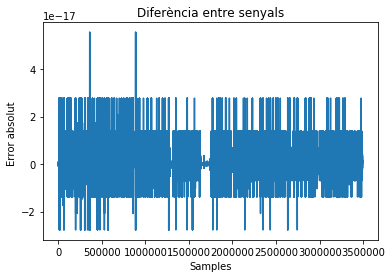

In [26]:
aux = data0-dataCoarse0
plt.title("Diferència entre senyals")
plt.xlabel("Samples")
plt.ylabel("Error absolut ")
plt.plot(aux[0])


print("L'error absolut màxim és: ", np.max(np.abs(aux)))

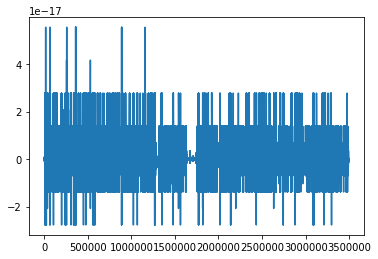

In [27]:
aux = data0-dataCoarse0
plt.plot(aux[1])